In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
torch.__version__

'1.6.0'

In [3]:
BATCH_SIZE=512 #大概需要2G的显存
EPOCHS=20 # 总共训练批次
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
DEVICE

device(type='cuda')

In [4]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/home/xingyu/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

tensor([0, 4, 8, 0, 9, 5, 9, 1, 5, 5, 5, 0, 3, 9, 5, 3, 4, 7, 9, 9, 2, 0, 3, 8,
        3, 8, 8, 5, 9, 1, 0, 4, 0, 4, 9, 6, 6, 2, 1, 4, 9, 1, 9, 7, 4, 0, 5, 8,
        5, 1, 3, 6, 3, 5, 8, 4, 6, 2, 4, 7, 8, 0, 1, 0, 0, 1, 8, 5, 7, 3, 6, 7,
        8, 3, 6, 4, 7, 7, 5, 0, 9, 1, 5, 2, 1, 1, 2, 4, 7, 4, 2, 6, 4, 1, 9, 5,
        3, 0, 8, 5, 4, 5, 2, 4, 8, 0, 0, 9, 5, 2, 5, 8, 5, 4, 9, 1, 4, 9, 1, 9,
        9, 5, 5, 1, 3, 9, 5, 9, 9, 4, 8, 0, 9, 4, 3, 5, 1, 9, 0, 2, 7, 1, 5, 7,
        6, 7, 9, 3, 8, 7, 9, 8, 0, 7, 0, 0, 1, 0, 2, 4, 0, 0, 7, 3, 5, 4, 6, 7,
        5, 6, 3, 0, 4, 6, 6, 2, 9, 8, 1, 0, 8, 3, 5, 2, 7, 3, 5, 7, 9, 3, 6, 1,
        1, 9, 1, 7, 5, 2, 7, 7, 0, 4, 4, 7, 9, 6, 2, 6, 9, 8, 1, 0, 4, 0, 2, 9,
        0, 5, 4, 3, 6, 1, 6, 3, 8, 1, 8, 0, 2, 0, 4, 8, 8, 1, 6, 3, 2, 5, 2, 9,
        9, 5, 9, 9, 7, 5, 7, 5, 2, 1, 3, 3, 8, 0, 8, 4, 2, 5, 0, 5, 2, 7, 4, 2,
        7, 2, 5, 2, 2, 6, 4, 5, 5, 4, 9, 9, 1, 6, 2, 2, 1, 7, 6, 4, 3, 4, 0, 4,
        1, 8, 6, 2, 6, 0, 5, 9, 8, 0, 0,

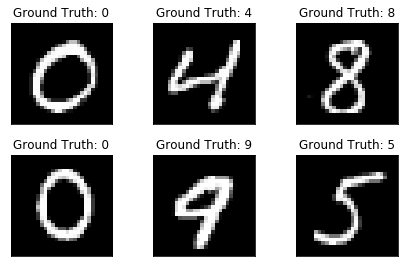

In [11]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets)
print(example_data.shape)
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1,28x28
        self.conv1=nn.Conv2d(1,10,5) # 10, 24x24
        self.conv2=nn.Conv2d(10,20,3) # 128, 10x10
        self.fc1 = nn.Linear(20*10*10,500)
        self.fc2 = nn.Linear(500,10)
    def forward(self,x):
        in_size = x.size(0)
        out = self.conv1(x) #24
        out = F.relu(out)
        out = F.max_pool2d(out, 2, 2)  #12
        out = self.conv2(out) #10
        out = F.relu(out)
        out = out.view(in_size,-1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.log_softmax(out,dim=1)
        return out

In [7]:
model = ConvNet().to(DEVICE)
optimizer = optim.Adam(model.parameters())


In [8]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if(batch_idx+1)%30 == 0: 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [9]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # 将一批的损失相加
            pred = output.max(1, keepdim=True)[1] # 找到概率最大的下标
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [10]:
for epoch in range(1, EPOCHS + 1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)


Train Epoch: 1 [14848/60000 (25%)]	Loss: 0.352452
Train Epoch: 1 [30208/60000 (50%)]	Loss: 0.169698
Train Epoch: 1 [45568/60000 (75%)]	Loss: 0.156325

Test set: Average loss: 0.1064, Accuracy: 9695/10000 (97%)

Train Epoch: 2 [14848/60000 (25%)]	Loss: 0.074486
Train Epoch: 2 [30208/60000 (50%)]	Loss: 0.086903
Train Epoch: 2 [45568/60000 (75%)]	Loss: 0.083561

Test set: Average loss: 0.0532, Accuracy: 9826/10000 (98%)

Train Epoch: 3 [14848/60000 (25%)]	Loss: 0.066145
Train Epoch: 3 [30208/60000 (50%)]	Loss: 0.060237
Train Epoch: 3 [45568/60000 (75%)]	Loss: 0.041225

Test set: Average loss: 0.0494, Accuracy: 9837/10000 (98%)

Train Epoch: 4 [14848/60000 (25%)]	Loss: 0.051022
Train Epoch: 4 [30208/60000 (50%)]	Loss: 0.046775
Train Epoch: 4 [45568/60000 (75%)]	Loss: 0.072948

Test set: Average loss: 0.0384, Accuracy: 9872/10000 (99%)

Train Epoch: 5 [14848/60000 (25%)]	Loss: 0.029399
Train Epoch: 5 [30208/60000 (50%)]	Loss: 0.025843
Train Epoch: 5 [45568/60000 (75%)]	Loss: 0.028170

Test 